![ga4](https://www.google-analytics.com/collect?v=2&tid=G-6VDTYWLKX6&cid=1&en=page_view&sid=1&dl=statmike%2Fvertex-ai-mlops%2FApplied+Forecasting&dt=BQML+Multivariate+Forecasting+with+ARIMA%2B+XREG.ipynb)

---
ToDo List As Model Type Moves from Preview to GA:
- [ ] Add comparison of result to Univariate
- [ ] Add univariate as pre-req then parse results to select series for multivariate
- [ ] Keep ToDo list as features come out:
    - [ ] multiple time-series with `time_series_id_col`
    - [ ] explanations
    - [ ] anomalies with `ml.detect_anomalies`
---

# BigQuery ML (BQML) - Multivariate Forecasting with ARIMA+ including external regressors

In this notebook we fit a forecasting model to the data reviewed and prepared in the [preparation notebook](./BigQuery%20Time%20Series%20Forecasting%20Data%20Review%20and%20Preparation.ipynb) - citibike bike rentals daily volume by station near Central Park in New York City.  For this attempt we keep the forecasting activity within the data warehouse by using BigQuery's built-in machine learning - often called BQML.  One of the model types available is ARIMA+ XREF (`model_type = 'ARIMA_PLUS_XREF'`).  This fits multivariate forecasts by using auto-regressive integrated moving average (ARIMA) models while also automatically handling many of the data pre and post processing steps required as well as including time varying covariates and linear regressors.  Each station will be forecasted separately by simply providing the station names as `start_station_name` to the input parameter `time_series_id_col` (**in preview this is not yet available and a `WHERE` clause is used to limit the data to a single station**).  The forecast will be evaluated with various provided metrics and we will use SQL to calculate customized metrics.  It is even possible to identify anomalies using BigQuery ML with the function `ML.DETECT_ANOMALIES` (**in preview this feature is not yet available**).

**MULTIVARIATE Forecasting with ARIMA+ including Linear External Regressors**

One of the model type available is ARIMA+ with XREG (`model_type = 'ARIMA_PLUS_XREG'`).  This  fits multivariate forecasts by using time variying covariates as linear external regressors.  This is an extention of ARIMA+ univariate forecasting where the inclusing of additional information can improve the forecast accuracy.  The weights from a linear regression of the covariates is aggregated with the ARIMA forecasts.

**UNIVARIATE Forecasting with ARIMA+**

Univariate forecasting with ARIMA+ is available directly with (`model_type = 'ARIMA_PLUS'`).  This fits univariate forecasts by using auto-regressive integrated moving average (ARIMA) models while also automatically handling many of the data pre and post processing steps required.  The forecast can be evaluated with various provided metrics and even using SQL to calculate customized metrics.  It is also possible to identify anomalies using BigQuery ML with the function `ML.DETECT_ANOMALIES`.  This model type is fit in the notebook [BQML Univariate Forecasting with ARIMA+](./BQML%20Univariate%20Forecasting%20with%20ARIMA+.ipynb).

**ARIMA+**

ARIMA is a statistical model of time series data that helps understand patterns and forecast future points in time.  The model is made up of three parts:
- AR, or autoregressive.  Indicates a variable is regressed against it own previous values.
    - `p`, the parameter that indicates the number of lags, or previous time points considered
- I, or integrated.  Indicates the values have been replaced with the difference between a value and the previous value.
    - `d`, the parameter that indicates the degree of differencing or number of times the data have had past value subtracted 
- MA, or moving avarge.  Indicates the regression error is a combination of value at various time in the past.
    - `q`, the parameter that indicates the order of the moving-average

Reference:
- [ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average)

**ARIMA+ XREF**

This can be thought of a ARIMAX.  The additional letter stands for external regressors.  As an extention of ARIMA is still has the `p`, `d` and `q` parameters and adds a parameter `b`:
- X, or external regressors.  Indicates time varying regressors are included.
    - `b`, the parameter for the number of weights from a linear regression of the external regressors

---

**Series Overview**

[This series](./readme.md) explores forecasting with Vertex AI, BigQuery ML, and additional open source frameworks.  Forecasting consist of following a measurement over time and exploring trends, the impact of seasonality (years, months, days, etc), holidays, and special events with the hope of using these insights to forecast into the near future.  Some method also incoporate observable measurements that impact demand to understand the relationships and make forecasting more accurate.

**Data Source: Citibike rentals in New York City**

This series uses Citibike rentals in New York city.  The bike stations near central park will be selected and the daily number bike trips that orignate from these stations will be followed over time.  This will illustrate some common forecasting issues due to new stations being introduced over time and some stations only have the most recent few months, or just weeks of data.  The data are found in the BigQuery Public datasets at: `bigquery-public-data.new_york.citibike_trips`.

**BigQuery ML (BQML) Overview**

[BigQuery ML](https://cloud.google.com/bigquery/docs/bqml-introduction) allows you to use `SQL` to constuct an ML workflow.  This is a great leap in productivity and flexibility when the data source is [BigQuery](https://cloud.google.com/bigquery/docs/introduction) and users are already familiar with `SQL`. Using just `SQL`, [multiple techniques](https://cloud.google.com/bigquery/docs/bqml-introduction#model_selection_guide) can be used for model training and even include [hyperparameter tuning](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-hp-tuning-overview).  It includes serverless [training, evaluation, and inference](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-e2e-journey) techniques for supervised, unsupervised, time series methods, even recommendation engines.  [Predictions](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-inference-overview) can be served directly in BigQuery which also include explainability measures. Predictive models can be [exported to their native framework](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-export-model) for portability, or even directly [registered to Vertex AI model registry](https://cloud.google.com/bigquery/docs/managing-models-vertex) for online predictions on Vertex AI Endpoints.  You can [import models into BigQuery ML](https://cloud.google.com/bigquery/docs/reference/standard-sql/inference-overview#inference_using_imported_models) from many common framework, or [connect to remotely hosted models](https://cloud.google.com/bigquery/docs/reference/standard-sql/inference-overview#inference_using_remote_models) on Vertex AI Endpoints. You can even directly use many [pre-trained models](https://cloud.google.com/bigquery/docs/reference/standard-sql/inference-overview#pretrained-models) in Vertex AI Like Cloud Vision API, Cloud Natural Language API, and Cloud Translate API.

A great starting point for seeing the scope of available methods is the [user journey for models](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-e2e-journey).  This repository also has a series of notebook based workflows for many BigQuery ML methods that can be reviewed here: [../03 - BigQuery ML (BQML)](../03%20-%20BigQuery%20ML%20(BQML)/readme.md).

---

**Prerequisites:**
- [BigQuery Time Series Forecasting Data Review and Preparation](./BigQuery%20Time%20Series%20Forecasting%20Data%20Review%20and%20Preparation.ipynb)
    - prepare data for this notebook

**Resources:**
- [Bigquery ML End-to-end user journey for each model](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-e2e-journey)
- [How to do time series forecasting in BigQuery](https://towardsdatascience.com/how-to-do-time-series-forecasting-in-bigquery-af9eb6be8159)
- [How to do multivariate time series forecasting in BigQuery ML](https://cloud.google.com/blog/products/data-analytics/how-to-do-multivariate-time-series-forecasting-in-bigquery-ml)
- [Vertex AI Forecast: An Overview](https://cloud.google.com/blog/topics/developers-practitioners/vertex-forecast-overview)
- [Codelab: Time Series Forecasting with Vertex AI and BigQuery ML](https://codelabs.developers.google.com/codelabs/time-series-forecasting-with-cloud-ai-platform#0)

**Conceptual Flow & Workflow**
<p align="center">
  <img alt="Conceptual Flow" src="../architectures/slides/afore2_arch.png" width="45%">
&nbsp; &nbsp; &nbsp; &nbsp;
  <img alt="Workflow" src="../architectures/slides/afore2_console.png" width="45%">
</p>

---
## Colab Setup

To run this notebook in Colab click [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Applied%20Forecasting/BQML%20Multivariate%20Forecasting%20with%20ARIMA+%20XREG.ipynb) and run the cells in this section.  Otherwise, skip this section.

This cell will authenticate to GCP (follow prompts in the popup).

In [1]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

In [473]:
try:
    import google.colab
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
except Exception:
    pass

---
## Setup

inputs:

In [1]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [2]:
REGION = 'us-central1'
EXPERIMENT = 'bqml-arimaplusxreg'
SERIES = 'applied-forecasting'

BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-','_')
BQ_TABLE = 'forecasting-data_prepped'

viz_limit = 12

packages:

In [3]:
from google.cloud import bigquery

import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

clients:

In [4]:
bq = bigquery.Client(project = PROJECT_ID)

---
## Review Time Series

Univariate forecasting consists if just 2 columns per time series:
- The demand measurment: `TARGET_COLUMN`.  In our case it is the number of trips taken per day from a particular bike station - the sum of trips for a day.
- The time of demand: `TIME_COLUMN`.  Expressed in the time or date units related to the granularity of the forecast exercise.  In our case, demand is measured daily so the time column is prepared as a date.  
    - For a different granularity, you may need to summarize the demand signal as a `SUM`, `MIN`, `MAX`, or `AVERAGE` for different time components.  
    - A very helpful BigQuery function for extracting components of times and dates is the `EXTRACT` function:
        - [EXTRACT as a date function](https://cloud.google.com/bigquery/docs/reference/standard-sql/date_functions#extract)
        - [EXTRACT as a time function](https://cloud.google.com/bigquery/docs/reference/standard-sql/time_functions#extract)
        - [EXTRACT as a datetime function](https://cloud.google.com/bigquery/docs/reference/standard-sql/datetime_functions#extract).

Conducting multiple forecasts, one per time series, means including a third column to capture the groups of rows for each time series: `SERIES_COLUMN`. BigQuery ARIMA+ fits a separate forecast for each of these groups. In our case this is the `start_station_name` or name for each individual Citibike station near Central Park.

Multivariate forecasting means including additional features: attributes and covariates.  To predict a forecasted value on the horizon a value for these will need be known.  While ARIMA+ XREF does not different these they are usually divided into three types:
- Attributes
    - Values that do not change over time but describe what the time series represents.  In our case a bike station might be identified by latitude and longitude, color, number of bike slots.
- Covariates that are available
    - These are measurements that can be known ahead of time like when holidays occur, promotions, events, changes in capacity.
- Covariates that are unavailable
    - Measurements that change over time but are not known until the time of measurment like rain, other weather, foot traffic, and queue length.

In [5]:
# CUSTOMIZE
TARGET_COLUMN = 'num_trips'
TIME_COLUMN = 'starttime'
SERIES_COLUMN = 'start_station_name'
COVARIATE_COLUMNS = ['avg_tripduration', 'pct_subscriber', 'ratio_gender', 'capacity'] # could be empty

Retrieve Key Dates for splits:

In [6]:
query = f"""
    WITH
        SPLIT AS (
            SELECT splits, min({TIME_COLUMN}) as mindate, max({TIME_COLUMN}) as maxdate
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
            GROUP BY splits
        ),
        TRAIN AS (
            SELECT mindate as start_date
            FROM SPLIT
            WHERE splits ='TRAIN'
        ),
        VAL AS (
            SELECT mindate as val_start
            FROM SPLIT
            WHERE splits = 'VALIDATE'
        ),
        TEST AS (
            SELECT mindate as test_start, maxdate as end_date
            FROM SPLIT
            WHERE splits = 'TEST'
        )
    SELECT * EXCEPT(pos) FROM
    (SELECT *, ROW_NUMBER() OVER() pos FROM TRAIN)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM VAL)
    USING (pos)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM TEST)
    USING (pos)
"""
keyDates = bq.query(query).to_dataframe()
keyDates

,start_date,val_start,test_start,end_date
0,2013-07-01,2016-09-03,2016-09-17,2016-09-30


Retrieve raw data:

In [7]:
query = f"""
    SELECT {SERIES_COLUMN}, {TIME_COLUMN}, {TARGET_COLUMN}, splits,
        {', '.join(COVARIATE_COLUMNS)}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    ORDER by {SERIES_COLUMN}, {TIME_COLUMN}
"""
rawSeries = bq.query(query).to_dataframe()

**NOTE DURING PREVIEW**

Only one series is forecasted due since the `time_series_id_col` parameter is not available during preview.  The chose `start_station` value for this notebook is: 'Central Park S & 6 Ave'

In [23]:
chosen_station = 'Central Park S & 6 Ave'
rawSeries = rawSeries[rawSeries[SERIES_COLUMN]==chosen_station]

### Plot Time Series - Overlay Covariates

Create an interactive chart for review individual time series (bike stations) and scrolling through the time range by using [Plotly](https://plotly.com/python/):

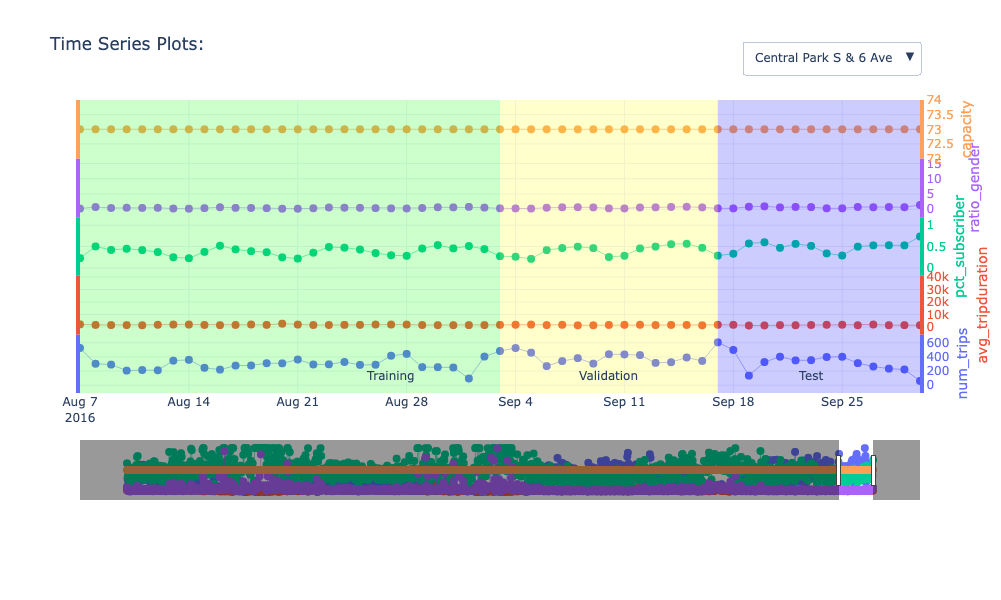

In [24]:
# NA values in Pandas will not convert to JSON which Plotly uses:
rawSeries = rawSeries.fillna(np.nan).replace([np.nan], [None])

# create a figure:
fig = go.Figure()

# get a list of colors to use:
colors = px.colors.qualitative.Plotly

# list of columns to plot over time : target and covariates
variables = [TARGET_COLUMN] + COVARIATE_COLUMNS

# create dropdown/button to toggle series
buttons = []
b = 0 # default button index

# iterate through series:
series = rawSeries[SERIES_COLUMN].unique().tolist()[0:viz_limit]
for s in series:
    # iterate trhough columns
    for y, v in enumerate(variables):
        fig.add_trace(
            go.Scatter(
                x = rawSeries[rawSeries[SERIES_COLUMN]==s][TIME_COLUMN],
                y = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                name = f'{v}',
                text = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                yaxis = f"y{y+1}",
                hoverinfo='name+x+text',
                line = {'width': 0.5},
                marker = {'size': 8},
                mode = 'lines+markers',
                showlegend = False,
                visible = (b==0) # make a series visible as default: this uses the first series
            )
        )
    
    # which button to show:
    ff = 0 # count of forecast related traces add to each series
    which_buttons = [False] * len(series) * (len(variables) + ff)
    which_buttons[b * (len(variables) +ff):(b+1)*(len(variables) + ff)] = [True] * (len(variables) + ff)

    # create button for series:
    button = dict(
        label = s,
        method = 'update',
        args = [{'visible': which_buttons}]
    )
    buttons.append(button)
    b += 1

# add split regions: training
fig.add_shape(
    fillcolor = 'rgba(0, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['start_date'][0],
    x1 = keyDates['val_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] - (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Training',
    yanchor = 'bottom'
)

# add split regions: validation
fig.add_shape(
    fillcolor = 'rgba(255, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['val_start'][0],
    x1 = keyDates['test_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] + (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Validation',
    yanchor = 'bottom'
)

# add split regions: test
fig.add_shape(
    fillcolor = 'rgba(0, 0, 255, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['test_start'][0],
    x1 = keyDates['end_date'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['test_start'][0] + (keyDates['end_date'][0]-keyDates['test_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Test',
    yanchor = 'bottom'
)

# configure axes layout:
layout = dict(
    xaxis =  dict(
        range = [keyDates['end_date'][0] - 2*(keyDates['end_date'][0] - keyDates['val_start'][0]), keyDates['end_date'][0]],
        rangeslider = dict(
            autorange = True,
            range = [keyDates['start_date'][0], keyDates['end_date'][0]]
        ),
        type = 'date'
    )
)
for v, variable in enumerate(variables):
    layout[f'yaxis{v+1}'] = dict(
        anchor = 'x',
        domain = [v*(1/len(variables)), (v+1)*(1/len(variables))],
        autorange = True,
        mirror = True,
        autoshift = True,
        title = dict(text = variable, standoff = 10 + 20 * (v % 2), font = dict(color = colors[v])),
        tickfont = dict(color = colors[v]),
        tickmode = 'auto',
        linecolor = colors[v],
        linewidth = 4,
        showline = True,
        side = 'right',
        type = 'linear',
        zeroline = False
    )

# final update of display before rendering
fig.update_layout(
    layout,
    title = 'Time Series Plots:',
    dragmode="zoom",
    hovermode="x",
    legend=dict(traceorder="reversed"),
    height=600,
    template="plotly_white",
    margin=dict(
        t=100,
        b=100
    ),
    updatemenus = [
        dict(
            buttons = buttons,
            type = 'dropdown',
            direction = 'down',
            x = 1,
            y = 1.2,
            showactive = True
        )
    ]
)

# render the interactive plot:
fig.show()

A Snapshot of the interactive plot:


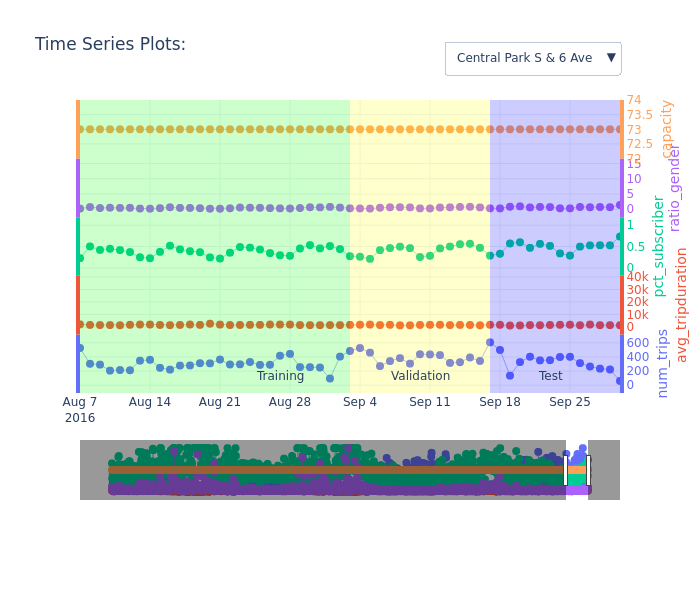

In [25]:
print('A Snapshot of the interactive plot:')
fig.show('png')

---
## Create Forecast Model
Use BigQuery ML Arima+ (`model_type = 'ARIMA_PLUS_XREG'`), a feature of [BigQuery ML](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-e2e-journey).  This does univariate time series modeling using ARIMA while also automating many of the task of this type of inference: preprocessing, holiday adjustments, spikes, dips, outlier, seasonal & trend decomposition, step change adjustment, trend modeling, forecasting.  A representation of this pipeline from the BigQuery ML documentation:

<p><center>
    <img alt="ARIMA_PLUS_XREG Flowchart" src="https://cloud.google.com/static/bigquery/images/BQ_ARIMA_PLUS_XREG_diagram.png" width="75%">
</center><p>

A deeper look at the ARIMA+ process:   
    
<p><center>
    <img alt="ARIMA_PLUS Flowchart" src="https://cloud.google.com/static/bigquery/images/BQ_ARIMA_diagram.png" width="75%">
</center><p>

**Note: In Preview a where statement is used to forecast a single station**
>Multiple time series are forcasted at the same time, each individual station near Central Park, using the `time_series_id_col >= ` input.

**Note:** ARIMA forecasting is univariate and does not use the validation data so we include it with the training data here:

In [10]:
# CUSTOMIZE
forecast_granularity = 'DAY'
forecast_horizon = 14
forecast_test_length = 14
#forecast_val_length = 14

In [27]:
query = f"""
    CREATE OR REPLACE MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`
    OPTIONS
      (model_type = 'ARIMA_PLUS_XREG',
       time_series_timestamp_col = '{TIME_COLUMN}',
       time_series_data_col = '{TARGET_COLUMN}',
       auto_arima_max_order = 5,
       holiday_region = 'US',
       horizon = {forecast_horizon}+{forecast_test_length}
      ) AS
    SELECT {TIME_COLUMN}, {TARGET_COLUMN},
        {', '.join(COVARIATE_COLUMNS)}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits in ('TRAIN','VALIDATE')
        AND {SERIES_COLUMN} = '{chosen_station}'
"""
print(query)


    CREATE OR REPLACE MODEL `statmike-mlops-349915.applied_forecasting.forecasting-data_prepped_arimaplusxreg`
    OPTIONS
      (model_type = 'ARIMA_PLUS_XREG',
       time_series_timestamp_col = 'starttime',
       time_series_data_col = 'num_trips',
       auto_arima_max_order = 5,
       holiday_region = 'US',
       horizon = 14+14
      ) AS
    SELECT starttime, num_trips,
        avg_tripduration, pct_subscriber, ratio_gender, capacity
    FROM `statmike-mlops-349915.applied_forecasting.forecasting-data_prepped`
    WHERE splits in ('TRAIN','VALIDATE')
        AND start_station_name = 'Central Park S & 6 Ave'



In [12]:
job = bq.query(query)
job.result()
print(job.state, (job.ended-job.started).total_seconds())

DONE 18.393


### Review The ARIMA Coefficients
Reference for [`ML.ARIMA_COEFFICIENTS`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-arima-coefficients)

In [13]:
query = f"""
    SELECT *
    FROM ML.ARIMA_COEFFICIENTS(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`)
"""
coefficients = bq.query(query).to_dataframe()
coefficients

,ar_coefficients,ma_coefficients,intercept_or_drift,processed_input,weight,category_weights
0,[],[],NaN,avg_tripduration,-1.513919e-03,[]
1,[],[],NaN,pct_subscriber,-3.021674e+02,[]
2,[],[],NaN,ratio_gender,2.385852e+00,[]
3,[],[],NaN,capacity,1.663402e+00,[]
4,[],[],NaN,__INTERCEPT__,3.435246e-11,[]
5,[],"[-0.8285042196372923, -0.2127548065971864, 0.6...",0.0,None,NaN,[]


### Review the input features
Reference for [`ML.FEATURE_INFO`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-feature)

In [14]:
query = f"""
    SELECT *
    FROM ML.FEATURE_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`)
"""
featureInfo = bq.query(query).to_dataframe()
featureInfo.head()

,input,min,max,mean,median,stddev,category_count,null_count,dimension
0,num_trips,1.000,555.000000,144.153912,130.000000,112.409702,<NA>,0,<NA>
1,starttime,NaN,NaN,NaN,NaN,NaN,1163,0,<NA>
2,avg_tripduration,336.625,34597.615385,1918.560216,1835.012000,1334.905339,<NA>,0,<NA>
3,pct_subscriber,0.000,1.000000,0.497785,0.465116,0.214707,<NA>,0,<NA>
4,ratio_gender,0.000,14.000000,0.908012,0.566667,1.329083,<NA>,26,<NA>


### Review the Training Information
Reference for [`ML.TRAINING_INFO`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-train#:~:text=For%20time%20series%20models)

In [15]:
query = f"""
    SELECT *
    FROM ML.TRAINING_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`)
"""
trainingInfo = bq.query(query).to_dataframe()
trainingInfo.head()

,training_run,iteration,duration_ms
0,0,0,8262


---
## Forecast Evaluation

### Forecast Metrics
Reference for [`ML.EVALUATE`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-evaluate#:~:text=ml.principal_component_info%20function.-,The%20ML.EVALUATE%20function%20returns,-the%20following%20columns) for `model_type = 'ARIMA_PLUS_XREG'`

The metrics returned depend on if input (test) data is provided and if `perform_aggregation` is `True` or `False`.  If `False` then metrics per timestamp are provide, and if `True` then metrics per `time_series_id_col` are provided.

In [16]:
query = f"""
    SELECT *
    FROM ML.EVALUATE(
        MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`,
        (
            SELECT {TIME_COLUMN}, {TARGET_COLUMN},
                {', '.join(COVARIATE_COLUMNS)}
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
            WHERE splits = 'TEST'
                AND {SERIES_COLUMN} = '{chosen_station}'
        ),
        STRUCT(TRUE AS perform_aggregation))
"""
metrics = bq.query(query).to_dataframe()
metrics

,mean_absolute_error,mean_squared_error,root_mean_squared_error,mean_absolute_percentage_error,symmetric_mean_absolute_percentage_error
0,84.689521,12568.571696,112.109641,37.609472,31.090433


### Evaluate Time Series Models
Reference for [`ML.ARIMA_EVALUATE`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-arima-evaluate)

A model metrics table:
ARIMA terms:
- p = how many autoregressive terms
- d =  how many nonseasonal differences needed for stationarity
- q = number of lagged forecast errors (moving average part)


In [17]:
query = f"""
    SELECT *
    FROM ML.ARIMA_EVALUATE(
        MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`,
        STRUCT(FALSE as show_all_candidate_models))
"""
arima_metrics = bq.query(query).to_dataframe()
arima_metrics

,non_seasonal_p,non_seasonal_d,non_seasonal_q,has_drift,log_likelihood,AIC,variance,seasonal_periods,has_holiday_effect,has_spikes_and_dips,has_step_changes,error_message
0,0,1,5,False,-5857.89421,11727.788421,1266.716816,"[WEEKLY, YEARLY]",True,True,False,


---
## Forecast Time Series
Reference for [`ML.FORECAST`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-forecast)

Calculates the forecasted value per timestamp and provides standard error and prediction intervals at the requested confidence level.

The default `horizon` is 3 so this parameter may need to be set to the size used at training.

**NOTE** When using external regressors their values are need for forecast to be computed.

In [28]:
query = f"""
    SELECT *
    FROM ML.FORECAST(
        MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`,
        STRUCT({forecast_test_length} AS horizon, 0.95 AS confidence_level),
        (
            SELECT {TIME_COLUMN}, {TARGET_COLUMN},
                {', '.join(COVARIATE_COLUMNS)}
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
            WHERE splits = 'TEST'
                AND {SERIES_COLUMN} = '{chosen_station}'
        )
        )
"""
forecast = bq.query(query).to_dataframe()
forecast

,forecast_timestamp,forecast_value,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound
0,2016-09-17 00:00:00+00:00,373.586424,35.590965,0.95,303.954192,443.218657
1,2016-09-18 00:00:00+00:00,461.201348,36.110552,0.95,390.552566,531.850130
2,2016-09-19 00:00:00+00:00,336.684705,36.140397,0.95,265.977532,407.391878
3,2016-09-20 00:00:00+00:00,238.410850,41.585960,0.95,157.049662,319.772038
4,2016-09-21 00:00:00+00:00,227.453134,48.100261,0.95,133.346990,321.559278
5,2016-09-22 00:00:00+00:00,208.416584,48.156590,0.95,114.200234,302.632934
6,2016-09-23 00:00:00+00:00,271.401457,48.212853,0.95,177.075030,365.727884
7,2016-09-24 00:00:00+00:00,379.234864,48.269051,0.95,284.798489,473.671240
8,2016-09-25 00:00:00+00:00,366.943810,48.325184,0.95,272.397613,461.490007
9,2016-09-26 00:00:00+00:00,257.832544,48.381251,0.95,163.176654,352.488435


## Forecast + Explanations for Time Series
Reference for [`ML.EXPLAIN_FORECAST`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-explain-forecast)

**NOTE** At this point in time (March 2023) the `ARIMA_PLUS_XREG` is in [preview](https://cloud.google.com/products#product-launch-stages) and does not yet use the `ML.EXPLAIN_FORECAST` function. In preparation for it the results of the forecast table above are used and remapped to the expected column names.

In [34]:
query = f"""
    SELECT *,
        '{chosen_station}' AS {SERIES_COLUMN},
        EXTRACT(DATE FROM forecast_timestamp) AS {TIME_COLUMN},
        forecast_value AS time_series_adjusted_data
    FROM ML.FORECAST(
        MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`,
        STRUCT({forecast_horizon+forecast_test_length} AS horizon, 0.95 AS confidence_level),
        (
            SELECT {TIME_COLUMN}, {TARGET_COLUMN},
                {', '.join(COVARIATE_COLUMNS)}
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
            WHERE {SERIES_COLUMN} = '{chosen_station}'
        )
        )
    ORDER BY {SERIES_COLUMN}, {TIME_COLUMN}
"""
explain = bq.query(query).to_dataframe()
explain

,forecast_timestamp,forecast_value,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,start_station_name,starttime,time_series_adjusted_data
0,2016-09-17 00:00:00+00:00,373.586424,35.590965,0.95,303.954192,443.218657,Central Park S & 6 Ave,2016-09-17,373.586424
1,2016-09-18 00:00:00+00:00,461.201348,36.110552,0.95,390.552566,531.850130,Central Park S & 6 Ave,2016-09-18,461.201348
2,2016-09-19 00:00:00+00:00,336.684705,36.140397,0.95,265.977532,407.391878,Central Park S & 6 Ave,2016-09-19,336.684705
3,2016-09-20 00:00:00+00:00,238.410850,41.585960,0.95,157.049662,319.772038,Central Park S & 6 Ave,2016-09-20,238.410850
4,2016-09-21 00:00:00+00:00,227.453134,48.100261,0.95,133.346990,321.559278,Central Park S & 6 Ave,2016-09-21,227.453134
5,2016-09-22 00:00:00+00:00,208.416584,48.156590,0.95,114.200234,302.632934,Central Park S & 6 Ave,2016-09-22,208.416584
6,2016-09-23 00:00:00+00:00,271.401457,48.212853,0.95,177.075030,365.727884,Central Park S & 6 Ave,2016-09-23,271.401457
7,2016-09-24 00:00:00+00:00,379.234864,48.269051,0.95,284.798489,473.671240,Central Park S & 6 Ave,2016-09-24,379.234864
8,2016-09-25 00:00:00+00:00,366.943810,48.325184,0.95,272.397613,461.490007,Central Park S & 6 Ave,2016-09-25,366.943810
9,2016-09-26 00:00:00+00:00,257.832544,48.381251,0.95,163.176654,352.488435,Central Park S & 6 Ave,2016-09-26,257.832544


### Visualize Time Series with Forecast

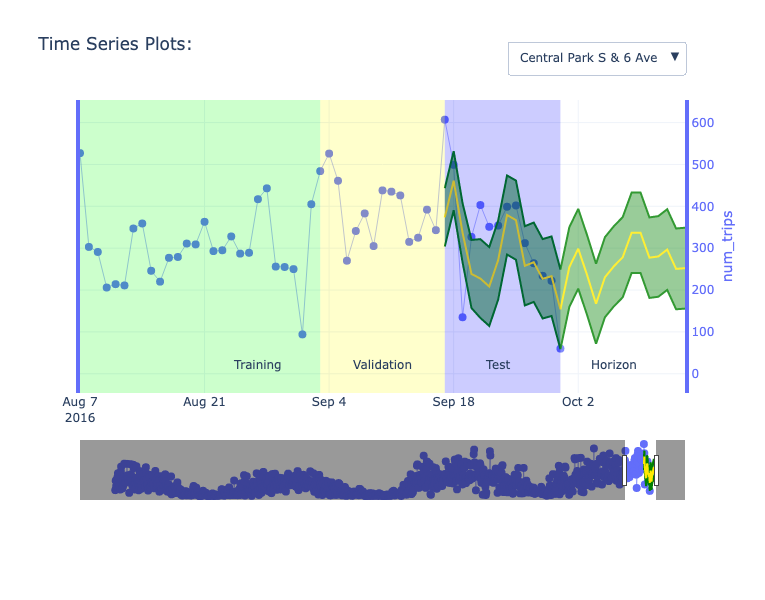

In [40]:
# NA values in Pandas will not convert to JSON which Plotly uses:
rawSeries = rawSeries.fillna(np.nan).replace([np.nan], [None])

# create a figure:
fig = go.Figure()

# get a list of colors to use:
colors = px.colors.qualitative.Plotly

# list of columns to plot over time : target and covariates
variables = [TARGET_COLUMN] #+ COVARIATE_COLUMNS

# create dropdown/button to toggle series
buttons = []
b = 0 # default button index

# iterate through series:
series = rawSeries[SERIES_COLUMN].unique().tolist()[0:viz_limit]
for s in series:    
    # iterate trhough columns
    for y, v in enumerate(variables):
        fig.add_trace(
            go.Scatter(
                x = rawSeries[rawSeries[SERIES_COLUMN]==s][TIME_COLUMN],
                y = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                name = f'{v}',
                text = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                yaxis = f"y{y+1}",
                hoverinfo='name+x+text',
                line = {'width': 0.5},
                marker = {'size': 8},
                mode = 'lines+markers',
                showlegend = False,
                visible = (b==0) # make a series visible as default: this uses the first series
            )
        )
        if y == 0: # add the forecast
            # add the forecast prediction funnel to test and horizon: lower
            fig.add_trace(
                go.Scatter(
                    x = explain[explain[SERIES_COLUMN]==s][TIME_COLUMN],
                    y = explain[explain[SERIES_COLUMN]==s]['prediction_interval_lower_bound'],
                    name = f'Lower Prediction: {v}',
                    text = explain[explain[SERIES_COLUMN]==s]['prediction_interval_lower_bound'],
                    yaxis = f"y{y+1}",
                    hoverinfo='name+x+text',
                    line = {'width': 2, 'color': 'rgb(0,128,0)'},
                    mode = 'lines',
                    showlegend = False,
                    visible = (b==0) # make a series visible as default: this uses the first series
                )
            )
            # add the forecast prediction funnel to test and horizon: upper
            fig.add_trace(
                go.Scatter(
                    x = explain[explain[SERIES_COLUMN]==s][TIME_COLUMN],
                    y = explain[explain[SERIES_COLUMN]==s]['prediction_interval_upper_bound'],
                    name = f'Upper Prediction: {v}',
                    text = explain[explain[SERIES_COLUMN]==s]['prediction_interval_upper_bound'],
                    yaxis = f"y{y+1}",
                    hoverinfo='name+x+text',
                    line = {'width': 2, 'color': 'rgb(0,128,0)'},
                    mode = 'lines',
                    fillcolor = 'rgba(0,128,0,0.5)',
                    fill = 'tonexty',
                    showlegend = False,
                    visible = (b==0) # make a series visible as default: this uses the first series
                )
            )
            # add the forecast fit
            fig.add_trace(
                go.Scatter(
                    x = explain[explain[SERIES_COLUMN]==s][TIME_COLUMN],
                    y = explain[explain[SERIES_COLUMN]==s]['time_series_adjusted_data'],
                    name = f'Forecast: {v}',
                    text = explain[explain[SERIES_COLUMN]==s]['time_series_adjusted_data'],
                    yaxis = f"y{y+1}",
                    hoverinfo='name+x+text',
                    line = {'width': 2, 'color': 'rgb(255,234,0)'},
                    mode = 'lines',
                    showlegend = False,
                    visible = (b==0) # make a series visible as default: this uses the first series
                )
            )
    
    # which button to show:
    ff = 3 # count of forecast related traces add to each series
    which_buttons = [False] * len(series) * (len(variables) + ff)
    which_buttons[b * (len(variables) +ff):(b+1)*(len(variables) + ff)] = [True] * (len(variables) + ff)

    # create button for series:
    button = dict(
        label = s,
        method = 'update',
        args = [{'visible': which_buttons}]
    )
    buttons.append(button)
    b += 1

# add split regions: training
fig.add_shape(
    fillcolor = 'rgba(0, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['start_date'][0],
    x1 = keyDates['val_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] - (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Training',
    yanchor = 'bottom'
)

# add split regions: validation
fig.add_shape(
    fillcolor = 'rgba(255, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['val_start'][0],
    x1 = keyDates['test_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] + (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Validation',
    yanchor = 'bottom'
)

# add split regions: test
fig.add_shape(
    fillcolor = 'rgba(0, 0, 255, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['test_start'][0],
    x1 = keyDates['end_date'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['test_start'][0] + (keyDates['end_date'][0]-keyDates['test_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Test',
    yanchor = 'bottom'
)

# add split regions: horizon
fig.add_shape(
    fillcolor = 'rgba(255, 255, 255, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['end_date'][0],
    x1 = keyDates['end_date'][0]+timedelta(days = forecast_horizon),
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['end_date'][0] + (keyDates['end_date'][0]-keyDates['test_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Horizon',
    yanchor = 'bottom'
)

# configure axes layout:
layout = dict(
    xaxis =  dict(
        range = [keyDates['end_date'][0] - 2*(keyDates['end_date'][0] - keyDates['val_start'][0]), keyDates['end_date'][0]+timedelta(days = forecast_horizon)],
        rangeslider = dict(
            autorange = True,
            range = [keyDates['start_date'][0], keyDates['end_date'][0]+timedelta(days = forecast_horizon)]
        ),
        type = 'date'
    )
)
for v, variable in enumerate(variables):
    layout[f'yaxis{v+1}'] = dict(
        anchor = 'x',
        domain = [v*(1/len(variables)), (v+1)*(1/len(variables))],
        autorange = True,
        mirror = True,
        autoshift = True,
        title = dict(text = variable, standoff = 10 + 20 * (v % 2), font = dict(color = colors[v])),
        tickfont = dict(color = colors[v]),
        tickmode = 'auto',
        linecolor = colors[v],
        linewidth = 4,
        showline = True,
        side = 'right',
        type = 'linear',
        zeroline = False
    )

# final update of display before rendering
fig.update_layout(
    layout,
    title = 'Time Series Plots:',
    dragmode="zoom",
    hovermode="x",
    legend=dict(traceorder="reversed"),
    height=600,
    template="plotly_white",
    margin=dict(
        t=100,
        b=100
    ),
    updatemenus = [
        dict(
            buttons = buttons,
            type = 'dropdown',
            direction = 'down',
            x = 1,
            y = 1.2,
            showactive = True
        )
    ]
)

# render the interactive plot:
fig.show()

A Snapshot of the interactive plot:


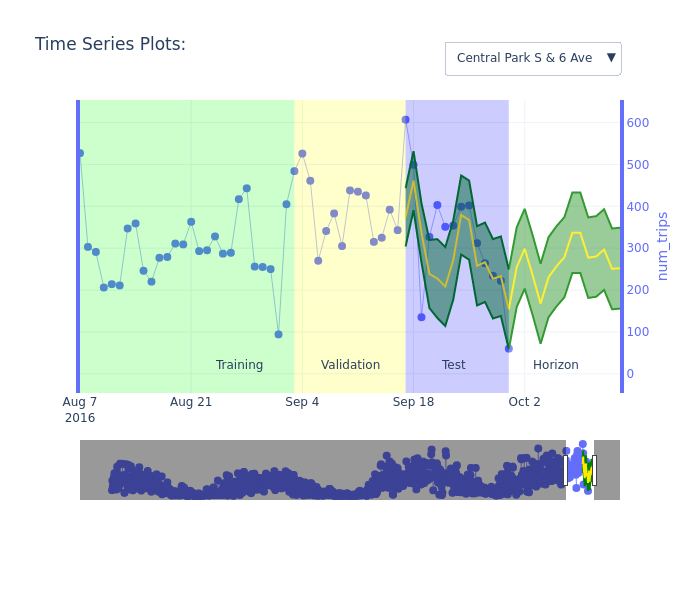

In [41]:
print('A Snapshot of the interactive plot:')
fig.show('png')

## Using SQL to Calculate Metrics

Some common metrics for evaluating forecasting effectiveness are 
- MAPE, or Mean Absolute Percentage Error
    - $\textrm{MAPE} = \frac{1}{n}\sum{\frac{\mid(actual - forecast)\mid}{actual}}$
- MAE, or Mean Absolute Error
     - $\textrm{MAE} = \frac{1}{n}\sum{\mid(actual - forecast)\mid}$
- MAE divided by average demand so it yields a % like MAPE
    - $\textrm{pMAE} = \frac{\sum{\mid(actual - forecast)\mid}}{\sum{actual}}$
- MSE, or Mean Squared Error
    - $\textrm{MSE} = \frac{1}{n}\sum{(actual-forecast)^2}$
- RMSE, or Root Mean Squared Error
    - $\textrm{RMSE} = \sqrt{\frac{1}{n}\sum{(actual-forecast)^2}}$
- RMSE divided by average demand so it yeilds a % like MAPE
    - $\textrm{pRMSE} = \frac{\sqrt{\frac{1}{n}\sum{(actual-forecast)^2}}}{\frac{1}{n}\sum{actual}}$

It can be helpful to explicity calculate these to make comparison between datasets and models fair.  This section demonstration these calculation with SQL.

>```sql
>(actual_value - forecast_value) as diff
>
>
>AVG(SAFE_DIVIDE(ABS(diff), actual_value)) as MAPE,
>AVG(ABS(diff)) as MAE,
>SAFE_DIVIDE(SUM(ABS(diff)), SUM(actual_value)) as pMAE,
>AVG(POW(diff, 2)) as MSE,
>SQRT(AVG(POW(diff, 2))) as RMSE,
>SAFE_DIVIDE(SQRT(AVG(POW(diff, 2))), AVG(actual_value)) as pRMSE
>```

In [32]:
query = f"""
    WITH    
        FORECAST AS (
            SELECT
                'Central Park S & 6 Ave' AS {SERIES_COLUMN},
                EXTRACT(DATE FROM forecast_timestamp) AS {TIME_COLUMN},
                forecast_value,
                'forecast' as time_series_type
            FROM ML.FORECAST(
                MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`,
                STRUCT({forecast_test_length} AS horizon, 0.95 AS confidence_level),
                (
                    SELECT {TIME_COLUMN}, {TARGET_COLUMN},
                        {', '.join(COVARIATE_COLUMNS)}
                    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
                    WHERE splits = 'TEST'
                        AND {SERIES_COLUMN} = '{chosen_station}'
                )   
            )
        ),
        ACTUAL AS (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, sum({TARGET_COLUMN}) as actual_value
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
            WHERE splits = 'TEST' AND {SERIES_COLUMN} = '{chosen_station}'
            GROUP BY {SERIES_COLUMN}, {TIME_COLUMN}
        ),
        COMBINED AS (
            SELECT *
            FROM FORECAST
            INNER JOIN ACTUAL
            USING ({SERIES_COLUMN}, {TIME_COLUMN})  
        ),
        DIFFS AS (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, 'forecast' as time_series_type, 
                actual_value, forecast_value, (actual_value - forecast_value) as diff
            FROM COMBINED
        )
    SELECT {SERIES_COLUMN}, time_series_type, 
            AVG(SAFE_DIVIDE(ABS(diff), actual_value)) as MAPE,
            AVG(ABS(diff)) as MAE,
            SAFE_DIVIDE(SUM(ABS(diff)), SUM(actual_value)) as pMAE,
            AVG(POW(diff, 2)) as MSE,
            SQRT(AVG(POW(diff, 2))) as RMSE,
            SAFE_DIVIDE(SQRT(AVG(POW(diff, 2))), AVG(actual_value)) as pRMSE
    FROM DIFFS
    GROUP BY {SERIES_COLUMN}, time_series_type
    ORDER BY {SERIES_COLUMN}, time_series_type    
"""
customMetrics = bq.query(query = query).to_dataframe()
customMetrics.head(viz_limit)

,start_station_name,time_series_type,MAPE,MAE,pMAE,MSE,RMSE,pRMSE
0,Central Park S & 6 Ave,forecast,0.376095,84.689521,0.2595,12568.571696,112.109641,0.343518


Overall Metrics:

In [33]:
query = f"""
    WITH
        FORECAST AS (
            SELECT
                'Central Park S & 6 Ave' AS {SERIES_COLUMN},
                EXTRACT(DATE FROM forecast_timestamp) AS {TIME_COLUMN},
                forecast_value,
                'forecast' as time_series_type
            FROM ML.FORECAST(
                MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`,
                STRUCT({forecast_test_length} AS horizon, 0.95 AS confidence_level),
                (
                    SELECT {TIME_COLUMN}, {TARGET_COLUMN},
                        {', '.join(COVARIATE_COLUMNS)}
                    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
                    WHERE splits = 'TEST'
                        AND {SERIES_COLUMN} = '{chosen_station}'
                )   
            )
        ),
        ACTUAL AS (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, sum({TARGET_COLUMN}) as actual_value
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
            WHERE splits = 'TEST'
            GROUP BY {SERIES_COLUMN}, {TIME_COLUMN}
        ),
        COMBINED AS (
            SELECT *
            FROM FORECAST
            INNER JOIN ACTUAL
            USING ({SERIES_COLUMN}, {TIME_COLUMN})  
        ),
        DIFFS AS (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, 'forecast' as time_series_type, 
                actual_value, forecast_value, (actual_value - forecast_value) as diff
            FROM COMBINED
        )
    SELECT time_series_type, 
        AVG(SAFE_DIVIDE(ABS(diff), actual_value)) as MAPE,
        AVG(ABS(diff)) as MAE,
        SAFE_DIVIDE(SUM(ABS(diff)), SUM(actual_value)) as pMAE,
        AVG(POW(diff, 2)) as MSE,
        SQRT(AVG(POW(diff, 2))) as RMSE,
        SAFE_DIVIDE(SQRT(AVG(POW(diff, 2))), AVG(actual_value)) as pRMSE
    FROM DIFFS
    GROUP BY time_series_type
    ORDER BY time_series_type    
"""
customMetricsOverall = bq.query(query).to_dataframe()
customMetricsOverall

,time_series_type,MAPE,MAE,pMAE,MSE,RMSE,pRMSE
0,forecast,0.376095,84.689521,0.2595,12568.571696,112.109641,0.343518


---
## Anomaly Detection
Reference for [`ML.DETECT_ANOMALIES`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-detect-anomalies)

**NOTE** At this point in time (March 2023) the `ARIMA_PLUS_XREG` is in [preview](https://cloud.google.com/products#product-launch-stages) and does not yet use the `ML.DETECT_ANOMALIES` function. This section will be completed once the feature is released.

---
## Remove Resources
see notebook "99 - Cleanup"